,K,D,OB,OS,Final,Trades,Momentum %,Swing %
0,14,7,70,10,1024638.00,606,34.5,65.5
1,14,7,80,10,1023872.75,397,37.5,62.5
2,21,5,70,20,1021976.75,933,33.7,66.3
3,21,5,80,10,1020057.00,579,36.4,63.6
4,21,7,80,10,1018641.25,470,37.4,62.6
5,21,5,70,10,1017673.00,733,34.7,65.3
6,14,5,70,20,1015731.25,876,34.2,65.8
7,14,5,80,20,1013843.25,749,35.9,64.1
8,21,5,80,20,1013572.75,807,35.2,64.8
9,5,5,80,20,1013445.00,410,39.5,60.5


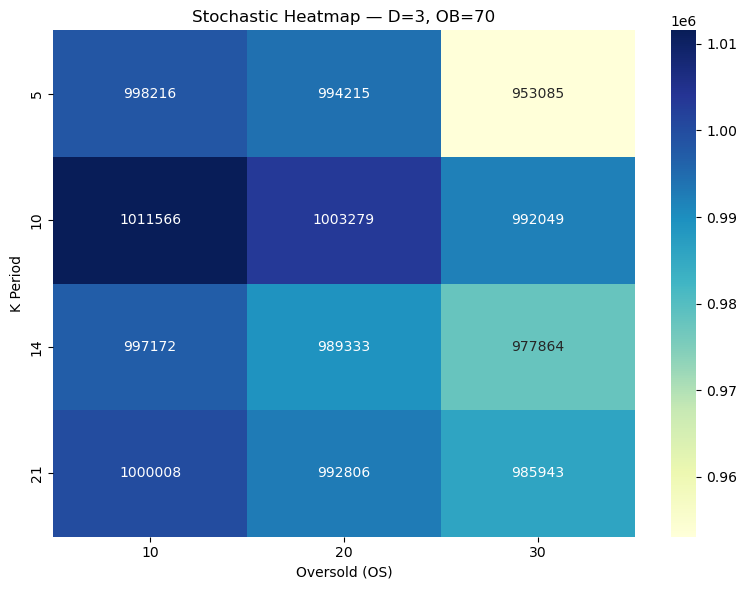

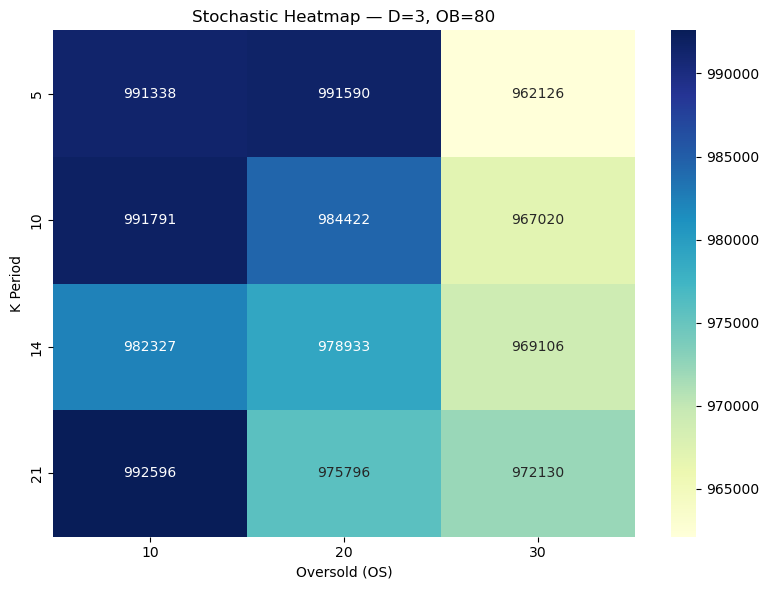

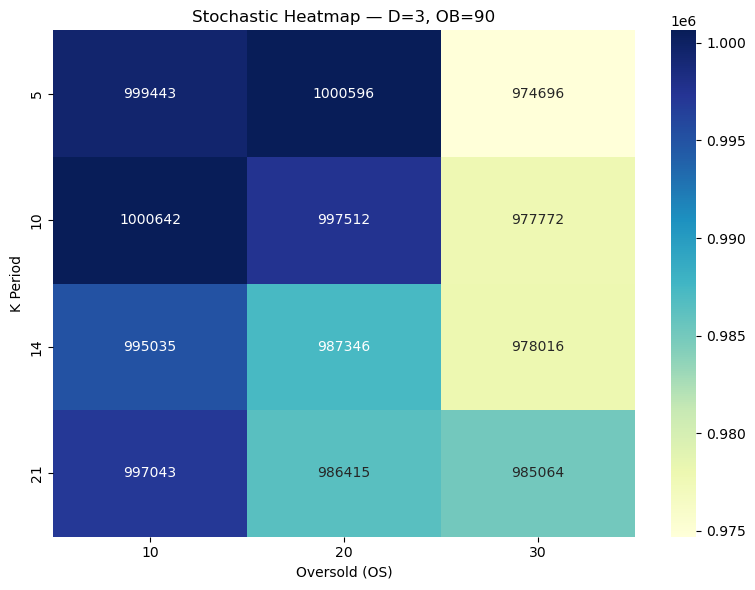

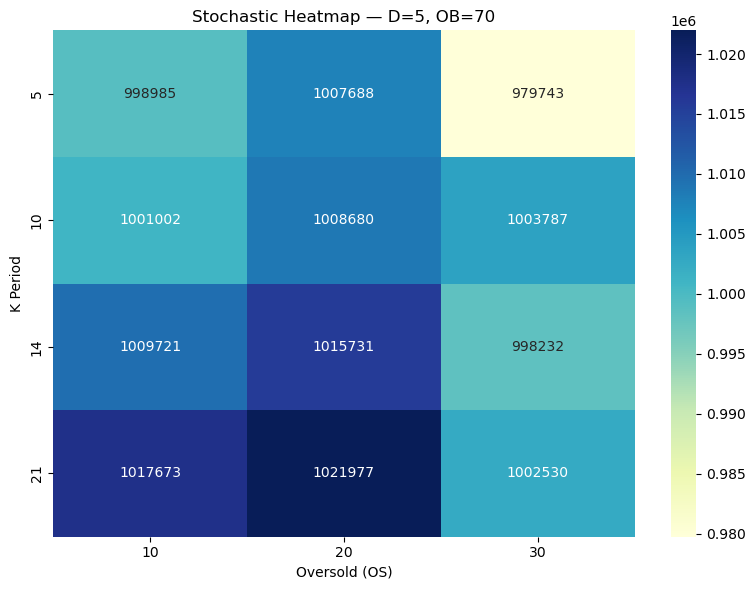

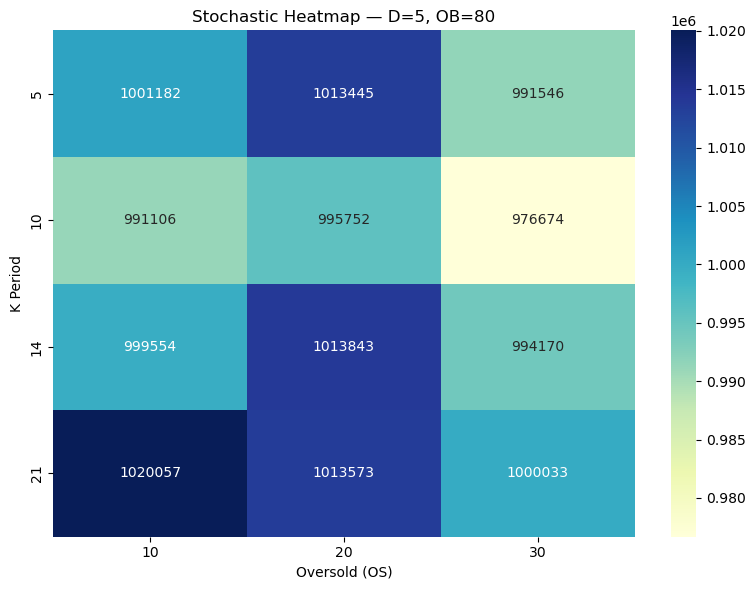

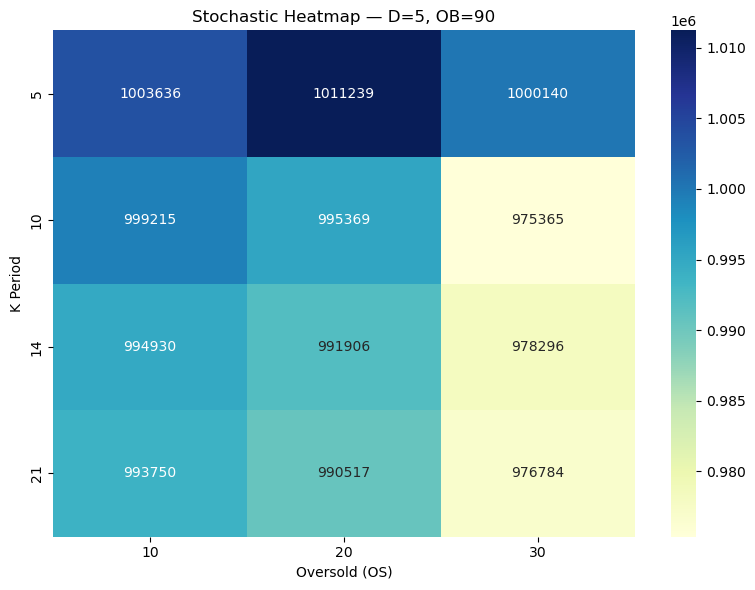

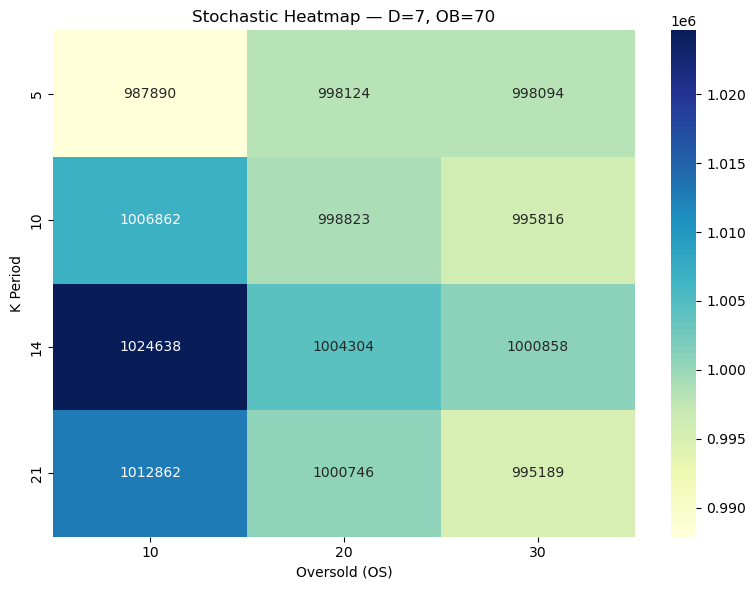

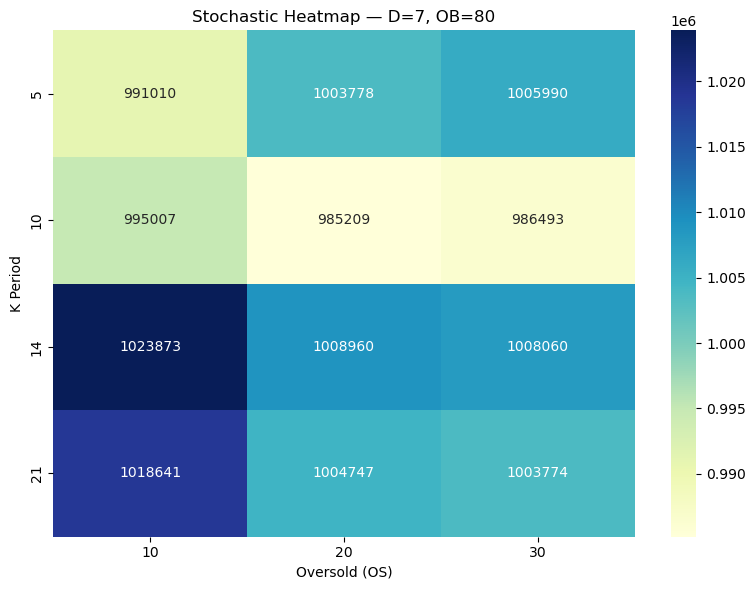

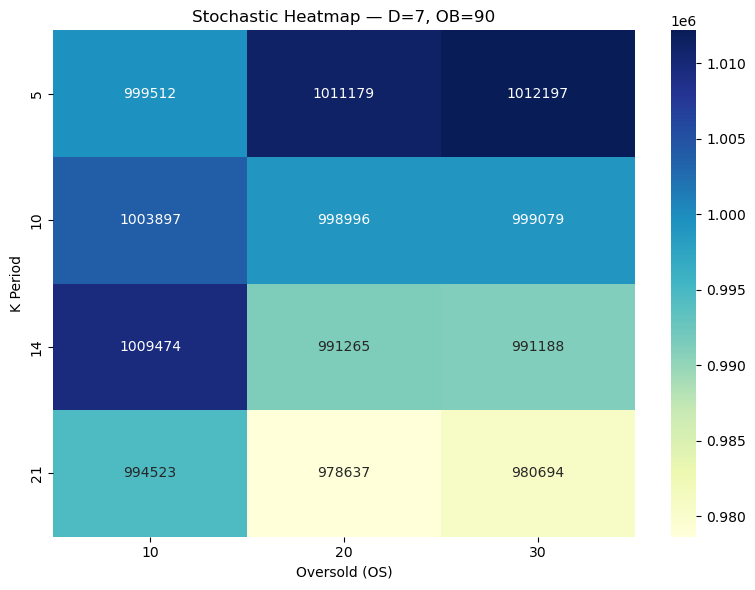

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── LOAD AND PREP DATA ─────────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=['timestamp']).set_index('timestamp')

# ─── Stochastic Parameter Grid ────────────────────────────────────────
k_periods = [5, 10, 14, 21]
d_periods = [3, 5, 7]
overbought_list = [70, 80, 90]
oversold_list = [10, 20, 30]

# ─── Constants ────────────────────────────────────────────────────────
VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW = 1.1, 0.9
CASH0, RISK_PCT = 1_000_000, 0.20
MAX_QTY = 500

# ─── Prepare Data ─────────────────────────────────────────────────────
df_stoch = df.copy()
df_stoch['VOL_S'] = df_stoch['volume'].rolling(VOL_WIN).mean()
df_stoch['VOL_L'] = df_stoch['volume'].rolling(VOL_MED_WIN).mean()
df_stoch['VOL_RATIO'] = df_stoch['VOL_S'] / df_stoch['VOL_L']

tr1 = df_stoch['high'] - df_stoch['low']
tr2 = (df_stoch['high'] - df_stoch['close'].shift()).abs()
tr3 = (df_stoch['low'] - df_stoch['close'].shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df_stoch['ATR'] = tr.rolling(14).mean()

results = []

# ─── Optimization Loop ────────────────────────────────────────────────
for k in k_periods:
    lowest_low = df_stoch['low'].rolling(k).min()
    highest_high = df_stoch['high'].rolling(k).max()
    df_stoch['%K'] = 100 * (df_stoch['close'] - lowest_low) / (highest_high - lowest_low)

    for d in d_periods:
        df_stoch['%D'] = df_stoch['%K'].rolling(d).mean()

        for ob in overbought_list:
            for os in oversold_list:
                df_stoch['Signal'] = 0
                # Long: %K crosses above %D below OS
                long_entry = (df_stoch['%K'].shift(1) < df_stoch['%D'].shift(1)) & \
                             (df_stoch['%K'] > df_stoch['%D']) & \
                             (df_stoch['%K'] < os)
                # Short: %K crosses below %D above OB
                short_entry = (df_stoch['%K'].shift(1) > df_stoch['%D'].shift(1)) & \
                              (df_stoch['%K'] < df_stoch['%D']) & \
                              (df_stoch['%K'] > ob)
                df_stoch.loc[long_entry, 'Signal'] = 1
                df_stoch.loc[short_entry, 'Signal'] = -1

                cash, pos = CASH0, 0
                stop = target = None
                equity = []
                num_trades = 0
                momentum_trades = 0
                swing_trades = 0

                for _, row in df_stoch.iterrows():
                    price = row['close']
                    atr = row['ATR']
                    sig = row['Signal']
                    vol_ratio = row['VOL_RATIO']

                    if pos > 0 and (price >= target or price <= stop):
                        cash += pos * price
                        pos = 0
                    elif pos < 0 and (price <= target or price >= stop):
                        cash -= -pos * price
                        pos = 0

                    if pos == 0 and sig != 0 and not np.isnan(atr) and not np.isnan(vol_ratio):
                        if vol_ratio > THR_HIGH or vol_ratio < THR_LOW:
                            qty = int((cash * RISK_PCT) / price)
                            qty = min(qty, MAX_QTY)

                            if sig == 1:
                                cash -= qty * price
                                pos = qty
                                stop = price - 2.0 * atr
                                target = price + 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1
                            elif sig == -1:
                                cash += qty * price
                                pos = -qty
                                stop = price + 2.0 * atr
                                target = price - 3.0 * atr
                                num_trades += 1
                                if vol_ratio > THR_HIGH:
                                    momentum_trades += 1
                                elif vol_ratio < THR_LOW:
                                    swing_trades += 1

                    equity.append(cash if pos == 0 else cash + pos * price)

                if equity:
                    results.append({
                        'K': k,
                        'D': d,
                        'OB': ob,
                        'OS': os,
                        'Final': equity[-1],
                        'Trades': num_trades,
                        'Momentum %': round(momentum_trades / num_trades * 100, 1) if num_trades > 0 else 0,
                        'Swing %': round(swing_trades / num_trades * 100, 1) if num_trades > 0 else 0
                    })

# ─── Results and Visuals ─────────────────────────────────────────────
df_stoch_res = pd.DataFrame(results)
summary = df_stoch_res.sort_values('Final', ascending=False).reset_index(drop=True)
display(summary.head(10))

# Optional export
# summary.to_csv("stochastic_summary.csv", index=False)
# print("Stochastic summary exported to 'stochastic_summary.csv'.")


# Heatmaps for fixed D and OB values
for fixed_d in sorted(df_stoch_res['D'].unique()):
    for fixed_ob in sorted(df_stoch_res['OB'].unique()):
        subset = df_stoch_res[(df_stoch_res['D'] == fixed_d) & (df_stoch_res['OB'] == fixed_ob)]
        pivot = subset.pivot(index='K', columns='OS', values='Final')
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
        plt.title(f"Stochastic Heatmap — D={fixed_d}, OB={fixed_ob}")
        plt.xlabel('Oversold (OS)')
        plt.ylabel('K Period')
        plt.tight_layout()
        plt.show()



In [3]:
print(f"Number of observations in dataset: {len(df)}")


Number of observations in dataset: 69055
